<a href="https://colab.research.google.com/github/amirhoseinoveis/GradCAM-with-MSTAR/blob/main/GradCAM_with_MSTAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import numpy as np
from tensorflow.keras.layers import  Input,Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix
import keras
import tensorflow as tf
import matplotlib


In [28]:

github_url = 'https://raw.githubusercontent.com/amirhoseinoveis/LIME_with_MSTAR/7f0ea0868eec651540c373570060728392070ff5/mstar_3cl_32by32.npz'

# Download the file using wget
path = '/content/mstar_3cl_32by32.npz'
os.system(f'wget {github_url} -O {path}')

# Load the data using np.load
with np.load(path) as data_mstar:
    x_train_mstar = data_mstar['x_train']
    y_train_mstar = data_mstar['y_train']
    x_test_mstar = data_mstar['x_test']
    y_test_mstar = data_mstar['y_test']
x_train_mstar=np.concatenate([x_train_mstar,x_train_mstar,x_train_mstar],axis=-1)
x_test_mstar=np.concatenate([x_test_mstar,x_test_mstar,x_test_mstar],axis=-1)



In [29]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img =( jet_heatmap * alpha + img)
    superimposed_img/=superimposed_img.max()

    matplotlib.pyplot.figure(figsize=(10, 5))
    matplotlib.pyplot.subplot(1, 3, 1)
    matplotlib.pyplot.title('Original Image')
    matplotlib.pyplot.imshow(img)

    matplotlib.pyplot.subplot(1, 3, 2)
    matplotlib.pyplot.title('Grad-CAM Heatmap')
    matplotlib.pyplot.imshow(heatmap, cmap='jet')

    matplotlib.pyplot.subplot(1, 3, 3)
    matplotlib.pyplot.title('Overlay of Grad-CAM')
    matplotlib.pyplot.imshow(superimposed_img)


In [30]:
inputs = Input(shape=(32,32,3),name="Input")
x = Conv2D(32, 3, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(16, 3, activation="relu",padding='same',name='Conv2')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
outputs= Dense(3,name='FC',activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 16, 16, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Vectorize (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC (Dense)                           │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,595 (33.57 KB)

 Trainable params: 8,595 (33.57 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:


hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on',
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - acc: 0.2969 - loss: 1.0813 - val_acc: 0.5810 - val_loss: 1.0041
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6259 - loss: 0.9844 - val_acc: 0.5714 - val_loss: 0.8765
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.6006 - loss: 0.8430 - val_acc: 0.5714 - val_loss: 0.8153
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6652 - loss: 0.7133 - val_acc: 0.7048 - val_loss: 0.6131
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7564 - loss: 0.5816 - val_acc: 0.8095 - val_loss: 0.4644
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8652 - loss: 0.4209 - val_acc: 0.9238 - val_loss: 0.3538
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9030 - loss: 0.3500 - val_acc: 0.9619 - val_loss: 0.2666
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9453 - loss: 0.2496 - val_acc: 0.9810 - val_loss: 0.1981
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9687 - loss:

In [32]:
classes_in=[0,1,2]
y_hat=model.predict(x_test_mstar)#test the model, prob.
#classification_report
CM=confusion_matrix(y_true=y_test_mstar,y_pred=y_hat.argmax(1))
# Display confusion matrix
print("Confusion Matrix:")
print(CM)
print("classification_report:")

print(classification_report(y_true=y_test_mstar,y_pred=y_hat.argmax(1)))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
[[248  26   0]
 [  4 268   2]
 [  1   1 272]]
classification_report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       274
           1       0.91      0.98      0.94       274
           2       0.99      0.99      0.99       274

    accuracy                           0.96       822
   macro avg       0.96      0.96      0.96       822
weighted avg       0.96      0.96      0.96       822



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


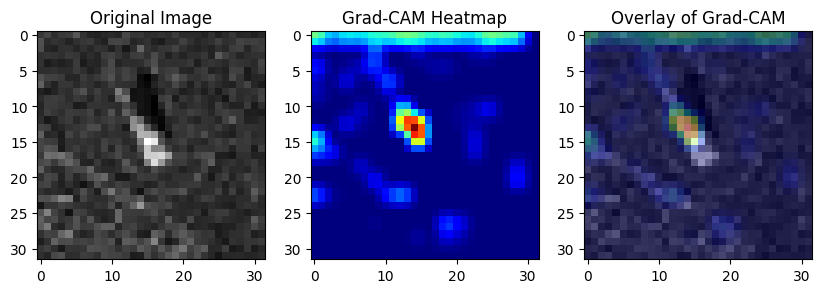

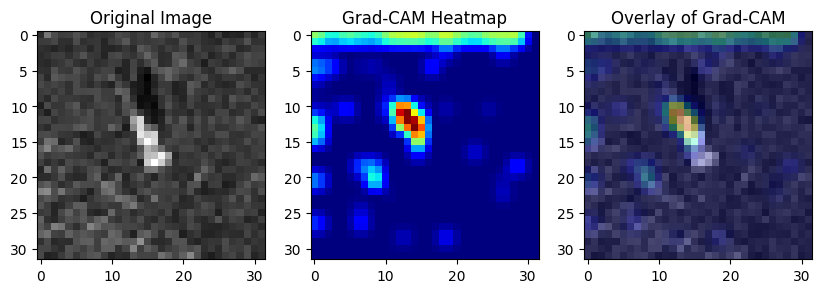

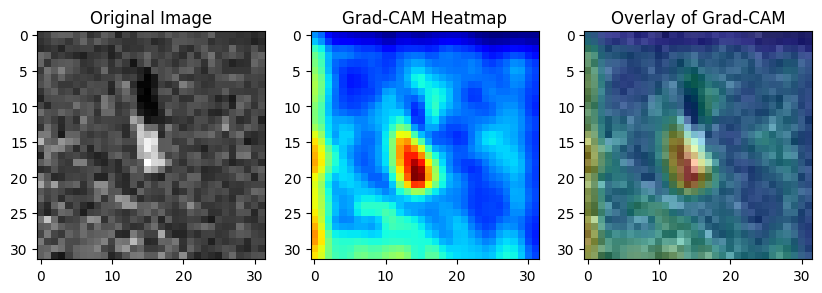

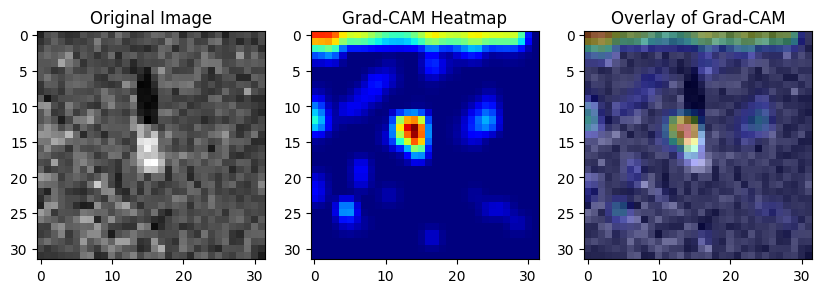

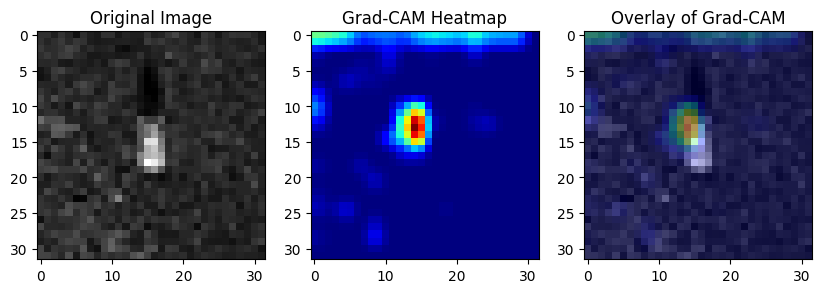

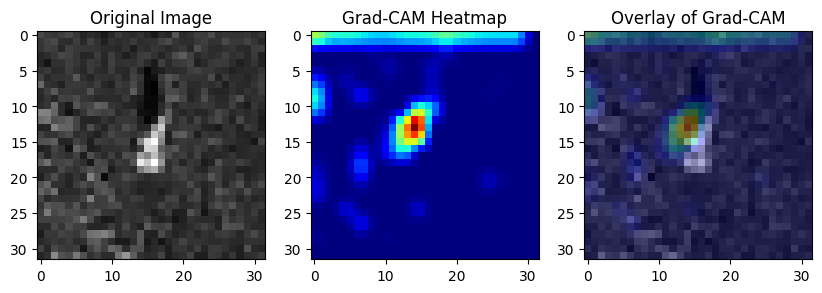

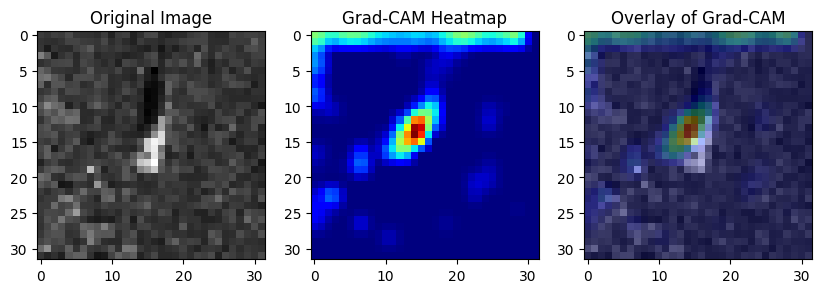

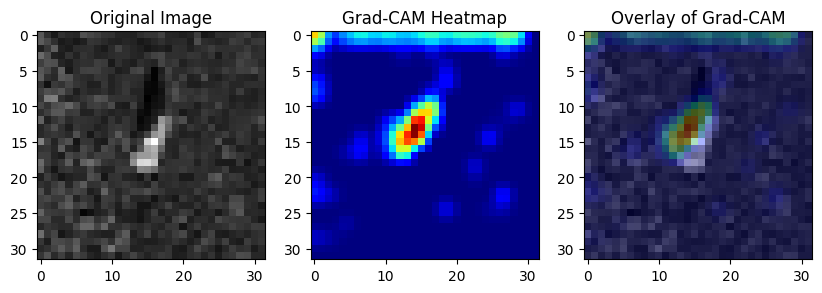

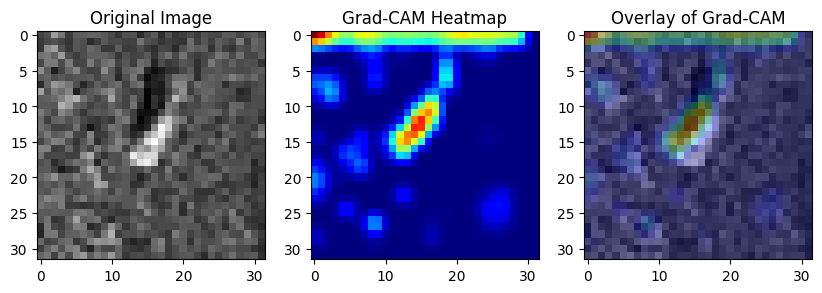

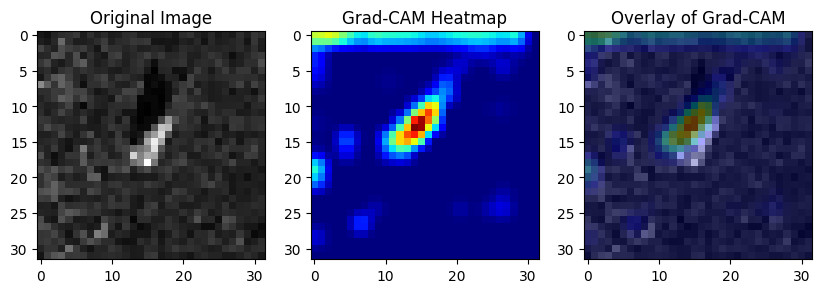

In [33]:
x_test=np.copy(x_test_mstar)
image_size=(32,32)

model.layers[-1].activation = None
for i in range(10) :

    img_array=x_test[i:i+1]
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name= "Conv2")

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], image_size)
    heatmap = tf.squeeze(heatmap).numpy()



    save_and_display_gradcam(np.uint8(255*np.squeeze((img_array-img_array.min())/(img_array.max()-img_array.min()))), heatmap)


In [34]:
make_gradcam_heatmap(img_array, model, last_conv_layer_name= "Conv2").shape



(16, 16)